# Predecir el coste del seguro médico de una persona

La importante compañía de seguros 4Geeks Insurance S.L. quiere calcular, en función de los datos fisiológicos de sus clientes, cuál va a ser la prima (coste) que debe asumir cada uno de ellos. Para ello, ha reunido a un equipo completo de médicos y en función de datos de otras compañías y un estudio particular han logrado reunir un conjunto de datos para entrenar un modelo predictivo.

In [290]:
import pandas as pd 
import numpy as np 

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# escalado y modelado
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score)
from sklearn.feature_selection import f_classif, SelectKBest


In [291]:
archivo = "https://breathecode.herokuapp.com/asset/internal-link?id=929&path=medical_insurance_cost.csv"
df = pd.read_csv(archivo, sep=",")

In [292]:
df.shape

(1338, 7)

In [293]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### Valores duplicados

In [295]:
duplicados = df.duplicated(keep=False)
num_duplicados = duplicados.sum()
print(f"Número de filas duplicadas: {num_duplicados}")
df_duplicados = df[duplicados]
print(df_duplicados)

Número de filas duplicadas: 2
     age   sex    bmi  children smoker     region    charges
195   19  male  30.59         0     no  northwest  1639.5631
581   19  male  30.59         0     no  northwest  1639.5631


In [296]:
df.drop_duplicates(keep='first', inplace=True)

In [297]:
df.duplicated().sum()

np.int64(0)

### Valores nulos

In [298]:
df.isnull().sum().sort_values(ascending=False)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Diferenciamos tipos de columnas (categóricas y numéricas)

In [299]:
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

print(f"Las variables numéricas son {num_cols}")
print(f"Las variables categóricas son {cat_cols}")

Las variables numéricas son Index(['age', 'bmi', 'children', 'charges'], dtype='object')
Las variables categóricas son Index(['sex', 'smoker', 'region'], dtype='object')


### Outliers

In [300]:
outliers_info = []

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)]
    outlier_pct = 100 * len(outliers) / len(df)

    outliers_info.append({
        "Variable": col,
        "Outliers (%)": round(outlier_pct, 2),
        "Q1": round(Q1, 2),
        "Q3": round(Q3, 2),
        "IQR": round(IQR, 2)
    })

tabla_outliers = pd.DataFrame(outliers_info)
print(tabla_outliers)

   Variable  Outliers (%)       Q1        Q3       IQR
0       age          0.00    27.00     51.00     24.00
1       bmi          0.67    26.29     34.70      8.41
2  children          0.00     0.00      2.00      2.00
3   charges         10.40  4746.34  16657.72  11911.37


age: 0% de outliers. Las edades están distribuidas entre 27 y 51 años.

bmi: 0.67% de outliers. Muy pocos casos con IMC extremos (probablemente obesidad muy alta o muy baja).

children: 0% de outliers. No hay valores fuera del rango típico (0 a 2 hijos).

charges: 10.4% de outliers. Hay un volumen alto de casos atípicos, lo que sugiere que hay clientes con gastos médicos anormalmente altos.

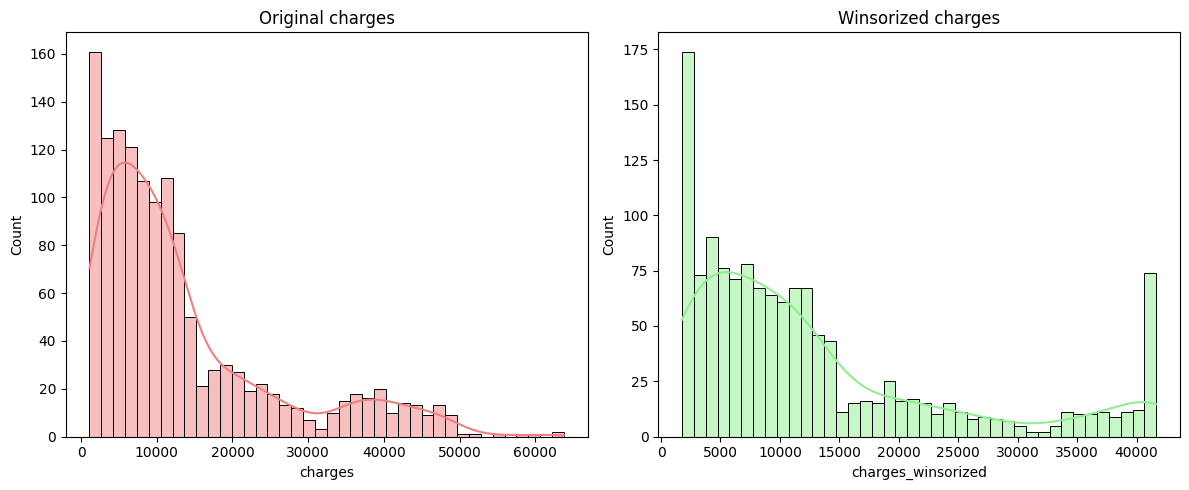

In [301]:
# Winsorización de columna charges sin alterar el original
df["charges_winsorized"] = winsorize(df["charges"], limits=[0.05, 0.05])

# Graficamos para ver la diferencia
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df["charges"], bins=40, ax=ax[0], color="lightcoral", kde=True)
ax[0].set_title("Original charges")

sns.histplot(df["charges_winsorized"], bins=40, ax=ax[1], color="lightgreen", kde=True)
ax[1].set_title("Winsorized charges")

plt.tight_layout()
plt.show()


Si comparamos los datos originales con el winsorizado vemos que la distribución está muy sesgada a la derecha. Hay una concentración de casos con gastos bajos y un pequeño grupo con valores muy altos.

En el gráfico tras la winsorización, hemos reducido la influencia de los outliers sin alterar la compresión general.

### Variables categóricas

In [302]:
df.sex.value_counts()

sex
male      675
female    662
Name: count, dtype: int64

In [303]:
df.smoker.value_counts()

smoker
no     1063
yes     274
Name: count, dtype: int64

In [304]:
df.region.value_counts()

region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64

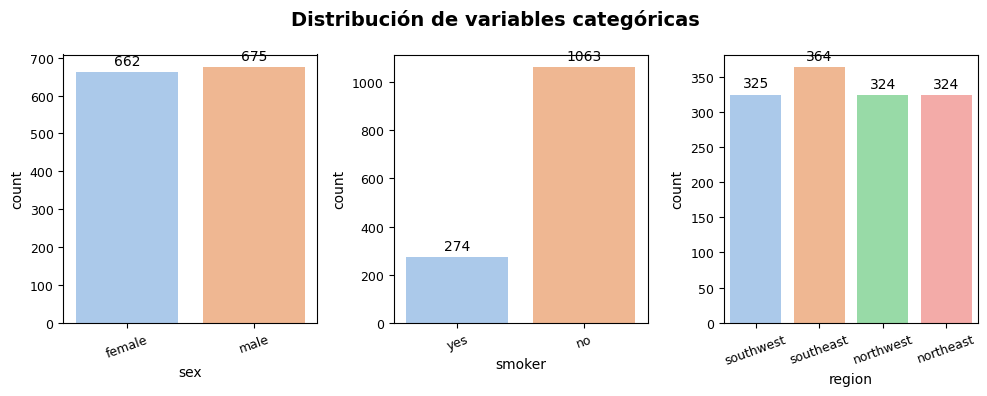

In [305]:
fig, axis = plt.subplots(1, 3, figsize = (10, 4))

sns.countplot(ax = axis[0], data = df, x = "sex", palette='pastel', hue= "sex", legend=False)
sns.countplot(ax = axis[1], data = df, x = "smoker", palette='pastel', hue= "smoker", legend=False)
sns.countplot(ax = axis[2], data = df, x = "region", palette='pastel', hue= "region", legend=False)

# Insertar valores númericos a las barras
for ax in axis:
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

    ax.set_xlabel(ax.get_xlabel(), fontsize=10)
    ax.set_ylabel(ax.get_ylabel(), fontsize=10)
    ax.tick_params(axis='x', labelsize=9, rotation=20)
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)

# Título general
fig.suptitle("Distribución de variables categóricas", fontsize=14, fontweight='bold')
# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

La distribución entre géneros es equilibrada: 662 females vs 675 males, con lo cual el análisis es equitativo por sexos.

Existen 1063 no fumadors vs 274 fumadores, lo cual es un 20.5% de smokers. Esto puede impactar en el análisis de charges, ya que habitualmente suele estar correlacionado con costes médicos más altos.

Las cuatro regiones del estudio también presentan una representación equitativa, sin predominancia de unas sobre otras.

### Variables numéricas

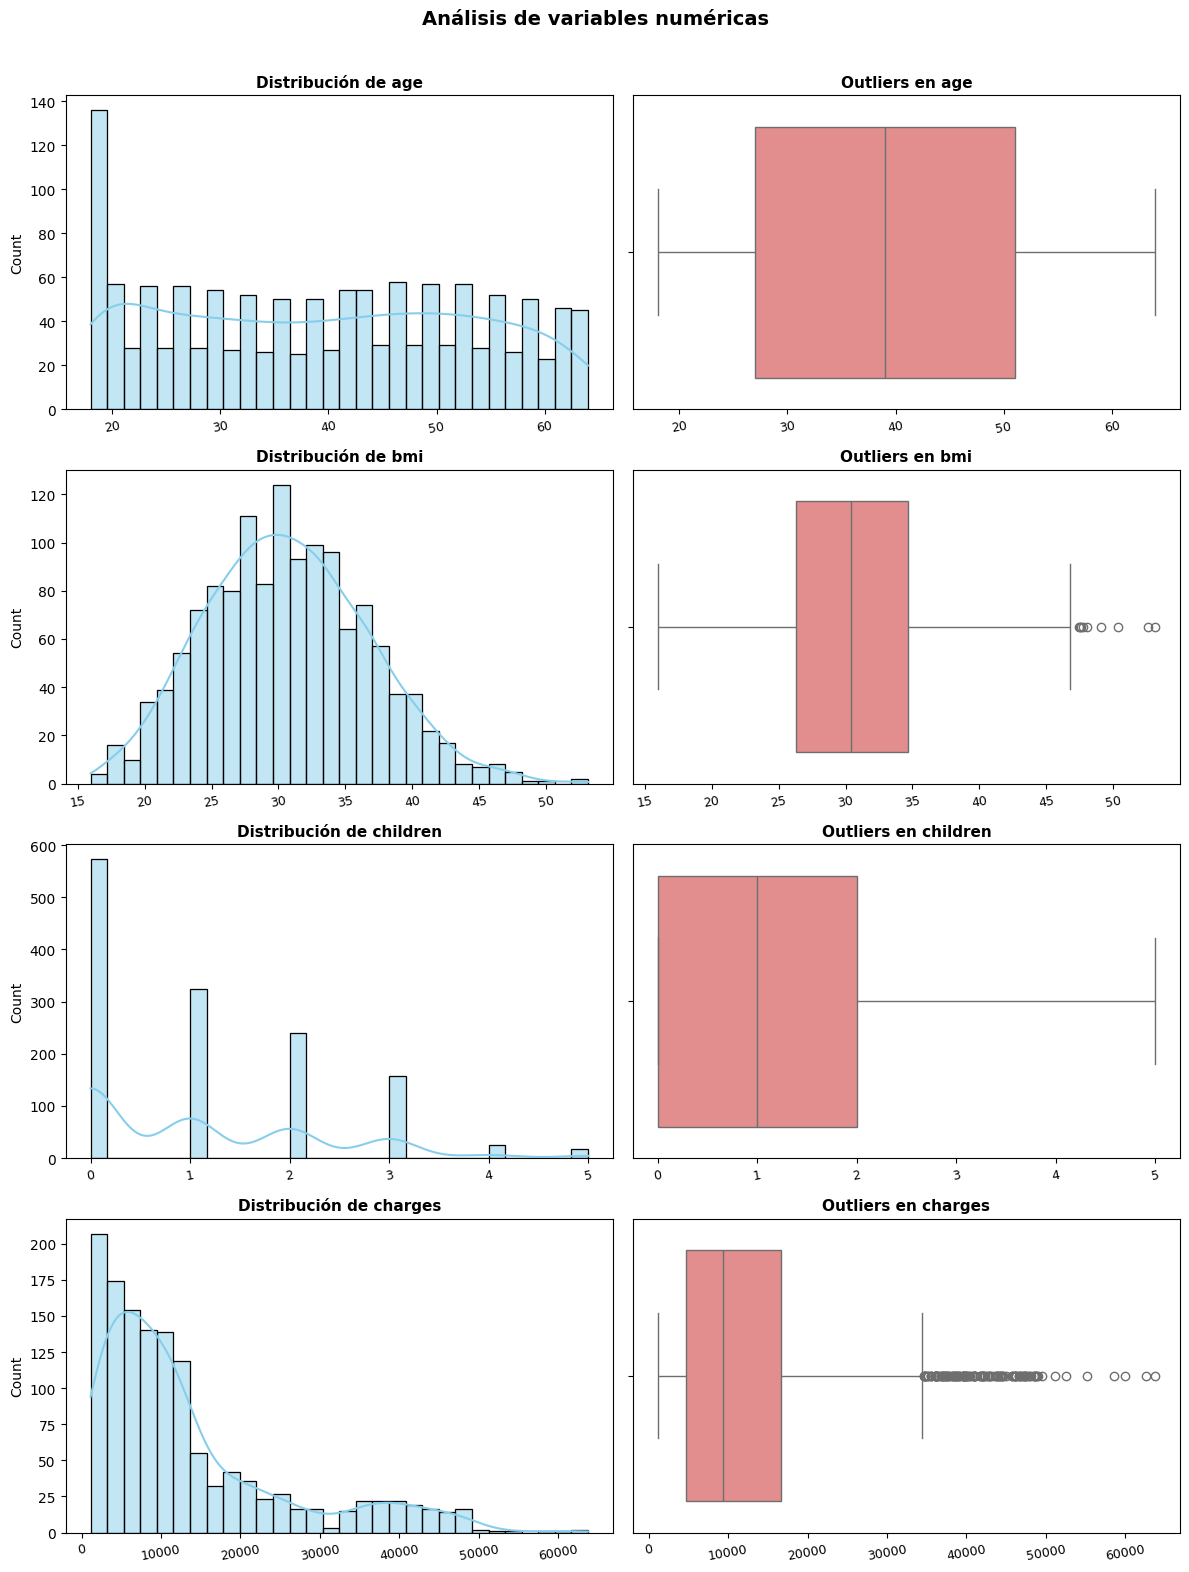

In [306]:
fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 4 * len(num_cols)))

for i, col in enumerate(num_cols):
    # Histograma
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f"Distribución de {col}", fontsize=11, fontweight='bold')
    axes[i, 0].set_xlabel("")
    axes[i, 0].tick_params(axis='x', labelsize=9, rotation=10)

    # Boxplot
    sns.boxplot(x=df[col], ax=axes[i, 1], color='lightcoral')
    axes[i, 1].set_title(f"Outliers en {col}", fontsize=11, fontweight='bold')
    axes[i, 1].set_xlabel("")
    axes[i, 1].tick_params(axis='x', labelsize=9, rotation=10)

fig.suptitle("Análisis de variables numéricas", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

age: la distribución de edades es bastante uniforme, con una ligera concentración en las edades de 18 a 25 años, pero sin outliers significativos.

bmi: en índice de masa corporal está ligeramente sesgada a la derecha concentrada entre 25-25 IMC, lo cuál indica una obesidad moderada. Existen algunos outliers en valores altos asociados a la obesidad mórbida de modo residual

children: la mayor parte de registros se encuentran entre 0 y 2 hijos, lo que sugiere familias pequeñas o sin hijos

charges: los gastos médicos mayoritarios están por debajo de los 15000 USD. Se confirma la presencia de outliers en pacientes con tratamientos costosos o presumiblemente, enfermedades crónicas.

### Análisis de las variables numéricas y la variable objetivo (charges)

charges               1.000000
charges_winsorized    0.993706
age                   0.298308
bmi                   0.198401
children              0.067389
Name: charges, dtype: float64


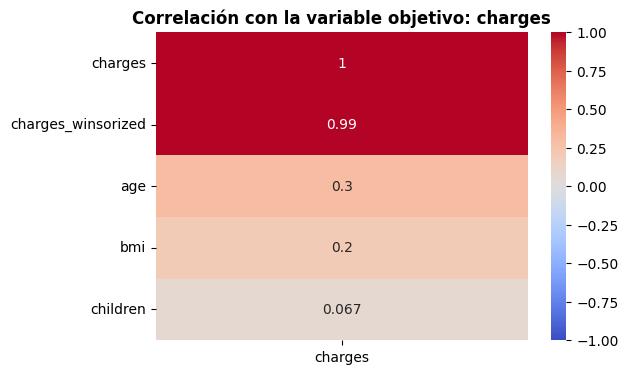

In [307]:
# Calcular correlaciones
corr = df.corr(numeric_only=True)['charges'].sort_values(ascending=False)

# Mostrar tabla ordenada
print(corr)

# Mapa de calor enfocado en las correlaciones con charges
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(numeric_only=True)[['charges']].sort_values(by='charges', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlación con la variable objetivo: charges", fontsize=12, fontweight='bold')
plt.show()


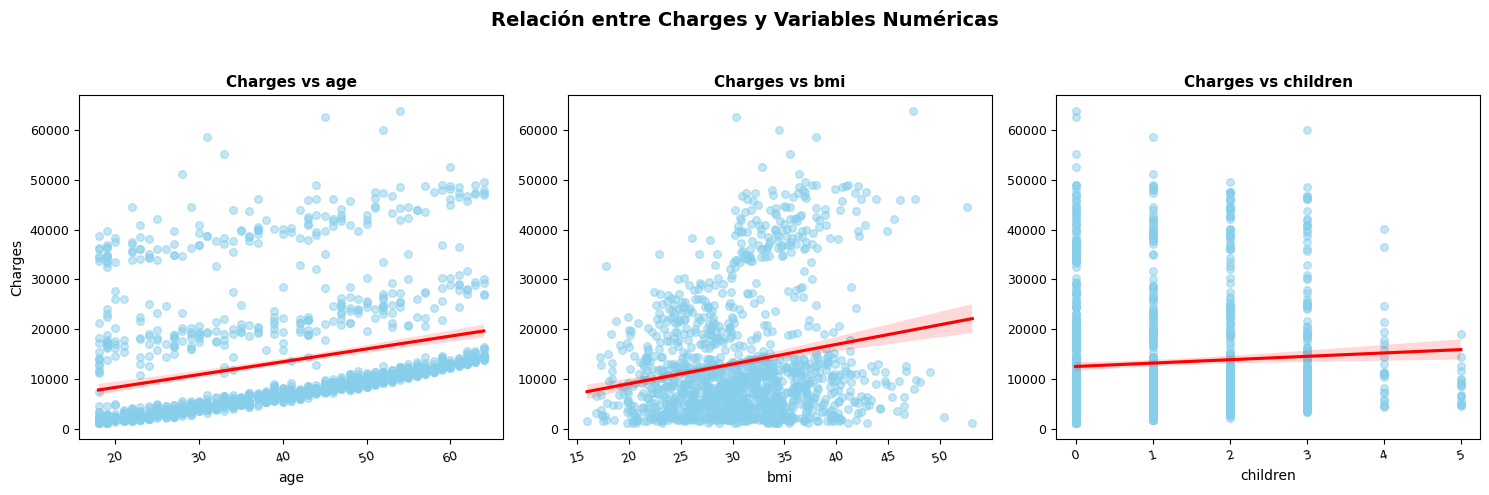

In [308]:
# Definimos las variables predictoras numéricas
num_vars = ['age', 'bmi', 'children']

# Creamos los subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(num_vars):
    sns.regplot(data=df, x=col, y='charges', ax=axes[i],
                scatter_kws={'alpha': 0.5, 's': 30},
                line_kws={'color': 'red'},
                color='skyblue')
    axes[i].set_title(f"Charges vs {col}", fontsize=11, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel("Charges" if i == 0 else "", fontsize=10)
    axes[i].tick_params(axis='x', labelsize=9, rotation=15)
    axes[i].tick_params(axis='y', labelsize=9)

fig.suptitle("Relación entre Charges y Variables Numéricas", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Las variables age y bmi son los principales predictores lineales de los costes médicos. A mayor edad y bmi, más coste. Las relaciones son positivas pero moderadas. Los valores más extremos de bmi muestran una correlación más clara

Las demás variables numéricas aportan información complementaria pero con menor peso explicativo. Los hijos no parece contribuir significativamente en los costes.

Dada la dispersión y asimetría observadas en charges, sería recomendable aplicar una transformación logarítmica antes de construir modelos predictivos, para mejorar la linealidad de las relaciones.

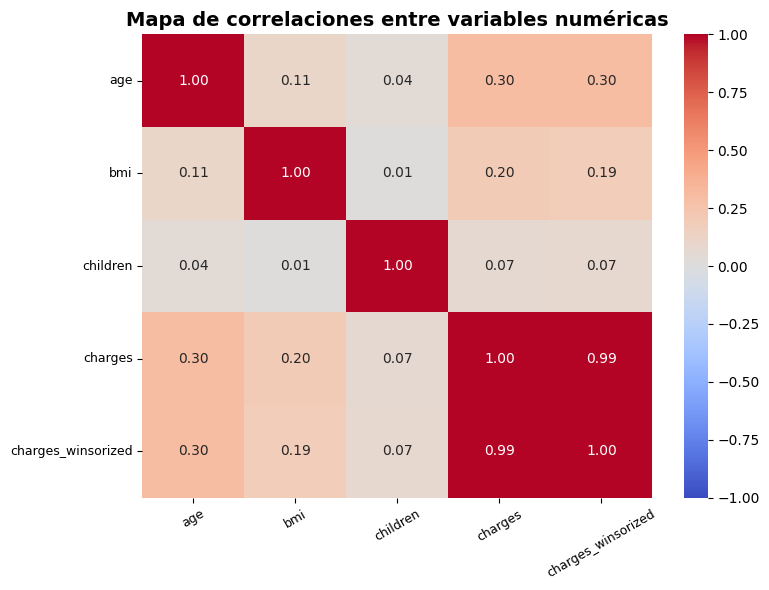

In [309]:
# Realizamos finalmente un heatmap de relaciones de todos con todos

# Seleccionamos solo las variables numéricas
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calculamos la matriz de correlación
corr_matrix = df[num_cols].corr(numeric_only=True)

# Visualizamos con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Mapa de correlaciones entre variables numéricas", fontsize=14, fontweight='bold')
plt.xticks(rotation=30, fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()


No existen correlaciones fuertes entre las variables independientes.Las relaciones más relevantes con la variable objetivo (charges) son positivas y moderadas, lo que sugiere que los costes médicos crecen con la edad y el IMC, pero no de forma lineal perfecta.

La variable children tiene poca influencia y podría descartarse en un modelo inicial sin pérdida significativa de poder explicativo.

In [310]:
# Añado escalación y encoding por tipo de categoría

num_cols = ['age', 'bmi', 'children']
cat_cols = ['sex', 'smoker', 'region']

X = df[num_cols + cat_cols]
y = df['charges']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Regresión Lineal

In [311]:
# Lo integramos en un pipeline para entrenarlo

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)
])

# Pipeline del modelo
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', LinearRegression())
])

# Entrenamiento
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Métricas

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("----- Modelo Multivariante: Regresión Lineal -----")
print(y_pred)
print(f"R2: {r2:.3f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

----- Modelo Multivariante: Regresión Lineal -----
[ 8.14369388e+03  5.73711568e+03  1.43693149e+04  3.17455136e+04
  8.96238666e+03  1.31497224e+04  3.04467607e+04  1.45328881e+03
  1.06330184e+04  1.13189438e+04  1.03778536e+04  3.31184377e+04
  3.10772527e+04  1.74119253e+04  1.08016743e+04  9.52889964e+03
  4.16103784e+03  3.17315373e+04  3.21938875e+03  5.22992460e+03
  3.54979004e+03  3.02837740e+04  1.48989509e+04  3.04569093e+04
  3.11077668e+04  5.51196081e+03  3.55030401e+04  3.65704810e+04
  1.14123133e+04  1.42056990e+04  6.50234029e+03  1.27246945e+04
  3.99806590e+02  1.20883980e+04  3.96592069e+04  1.23395540e+04
  4.74412279e+03  3.91903157e+03  3.08606789e+04  8.95870663e+03
  7.05389441e+03  3.01125636e+04  3.47804324e+04  1.22916189e+04
  7.35739310e+03  3.42060530e+03  6.21243471e+03  8.98345200e+03
  4.26401828e+03  9.01992870e+03  6.60149578e+03  1.20802337e+04
  3.12447687e+04  3.55341947e+03  1.10470477e+04  9.73512492e+03
  1.08383403e+04  2.42942719e+03  3.116

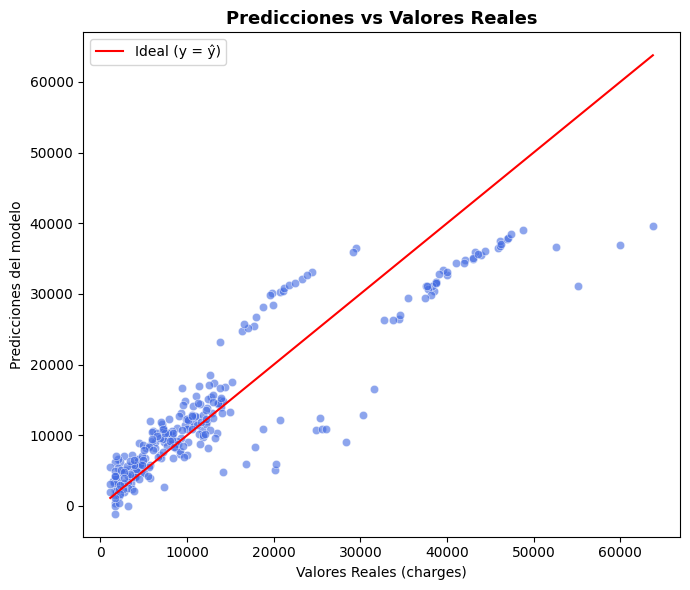

In [312]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='royalblue')
sns.lineplot(x=y_test, y=y_test, color='red', label='Ideal (y = ŷ)')
plt.title('Predicciones vs Valores Reales', fontsize=13, fontweight='bold')
plt.xlabel('Valores Reales (charges)')
plt.ylabel('Predicciones del modelo')
plt.legend()
plt.tight_layout()
plt.show()


Hay una alta dispersión en valores grandes de charges (heterocesdastidad). Hay influencia de variables como smoker o region que no parece captar este modelo. Al probar inicialmente con el modelo Lasso no hallé ninguna diferencia notable en el resultado de los modelos, así que opté por crear variables más complejas para analizar

## Regularización con modelo Lasso
Añado 3 nuevas variables de interacción para ver el rendimiento con Lasso

In [313]:
# Interacción entre edad y BMI (puede reflejar efecto combinado sobre los costes)
df['bmi_age_interaction'] = df['bmi'] * df['age']

# Interacción entre edad y número de hijos
df['age_children_interaction'] = df['age'] * df['children']

# Cuadrado del BMI (relación no lineal)
df['bmi_squared'] = df['bmi'] ** 2

In [314]:
# Actualizamos las columnas numéricas
num_cols = ['age', 'bmi', 'children', 
            'bmi_age_interaction', 'age_children_interaction', 'bmi_squared']
cat_cols = ['sex', 'smoker', 'region']

# Variables de entrada y salida
X = df[num_cols + cat_cols]
y = df['charges']

# División train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [315]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)
])

# Modelo Lasso con regularización
model_lasso = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', Lasso(alpha=1.0, random_state=42))
])

# Entrenamiento
model_lasso.fit(X_train, y_train)

# Predicción y métricas
y_pred_lasso = model_lasso.predict(X_test)

r2_lasso = r2_score(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print("----- Modelo Lasso con interacciones -----")
print(f"R2: {r2_lasso:.3f}")
print(f"MAE: {mae_lasso:.2f}")
print(f"RMSE: {rmse_lasso:.2f}")

----- Modelo Lasso con interacciones -----
R2: 0.803
MAE: 4334.37
RMSE: 6010.31


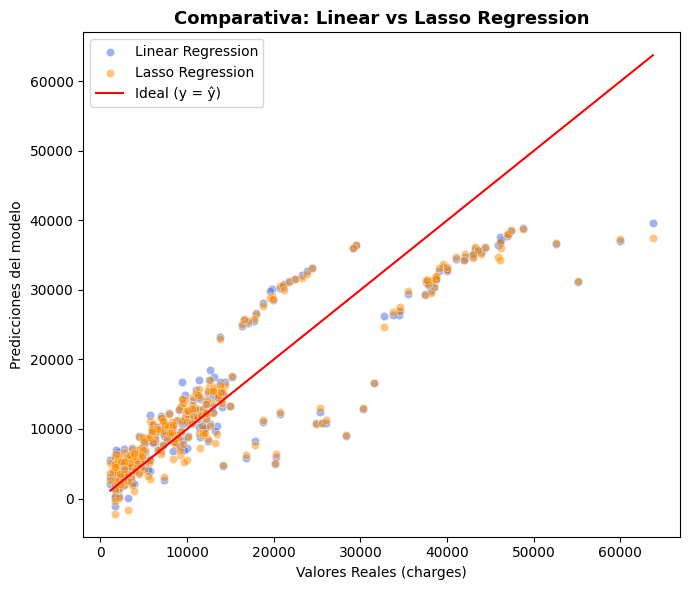

In [316]:
plt.figure(figsize=(7, 6))

# Regresión Lineal
sns.scatterplot(x=y_test, y=y_pred, color='royalblue', alpha=0.5, label='Linear Regression')

# Lasso
sns.scatterplot(x=y_test, y=y_pred_lasso, color='darkorange', alpha=0.5, label='Lasso Regression')

# Línea ideal
sns.lineplot(x=y_test, y=y_test, color='red', label='Ideal (y = ŷ)')

plt.title('Comparativa: Linear vs Lasso Regression', fontsize=13, fontweight='bold')
plt.xlabel('Valores Reales (charges)')
plt.ylabel('Predicciones del modelo')
plt.legend()
plt.tight_layout()
plt.show()


### Comparativa de Modelos

| Modelo                  | R2     | MAE   | RMSE  |
|--------------------------|--------|-------|-------|
| **Regresión Lineal**     | 0.807  | 4177  | 5956  |
| **Lasso + Interacciones**| 0.803  | 4334  | 6010  |

### Conclusiones:

El modelo base ya extrae casi toda la señal disponible.Lasso original y lasso con interacciones no mejoran este modelo porque no hay relaciones adicionales relevantes. Lasso no aporta valor añadido al modelo